# Grover's algorithm

Grover's algorithm is a search algorithm for unordered lists. It has a beautiful geometric motivation and considerably reduces the time complexity of this problem compared to the best known Classical algorithms.

In this notebook, we will analyze the time complexity of both the Classical and Grover's search algorithm, get a better understanding behind the theory underlying Grover's algorithm and also implement it using `Qiskit`.

## Classical Algorithm

Classicaly this is a simple problem to solve. What one does is iterate the list and compare each of the elements to the desired element until it is found, or until the list ends. Let's quickly implement this:

In [1]:
def ClassicalSearch(v, k):
    """
    A function to find element k in a list v
    """
    
    r = 0 
    while r < v.size and v[r] != k:
        r += 1
        
    return r

To analyze the time complexity of this algorithm, we first have to notice that the time it takes to compute this depends on the content of the list itself. Therefore, we will analyze three scenarios:
1. **Best case**: a scenario where the algorithm assimptotically takes the least amount of time
2. **Worst case**: a scenario where the algorithm assimptotically takes the most amount of time
3. **Average case**: the amount of time this algorithm takes on average

### Best case

In the best case the element we are looking for is always at the beggining of our list. If this is the case, we don't even enter the `while` cycle, which means the function executes in constant time relative to the size of the list. Since this is the best case, this means that the algorithm has a lower time complexity bound of $\Theta(1)$:

$$ T(N) \in \Omega(1) $$

### Worst Case

In the worst case the element we are looking for is not in the list, which makes us iterate all its elements. This means that the time it takes to execute the function will depend linearly in the size of the list, therefore, the time it takes to execute this function has an upper bound of $\Theta(N)$:

$$ T(N) \in \mathcal{O}(N)$$

By making use of the upper and lower bounds, we can state that:

$$ T(N) \in \Omega(1) \cap \mathcal{O}(N) \Leftrightarrow T(N) \in \mathcal{O}(N) $$

### Average Case

We can also determine the time complexity of this algorithm on average. This is a little more specific than the two above cases, because to determine this we must first assume a distribution for our list elements to follow. Let's say that the probability of any element of the list being the desired element is $p$. 

With this assumption, for the `while` cycle to stop at iteration $i$ in our `ClassicalSearch` function, the first $i-1$ elements can't be equal to our desired element (the probability of this ocurring is $(1-p)^{i-1}$) and the $i$-th element is equal to that desired element (probability given by $p$). 

If we then take into account all possible stopping points for our `ClassicalSearch` function, count the number of instructions performed by each of these cases and weight them by their respective likelihood probabilities, we get that on average:

$$ \mathbb{E}[T(N)] = N (1-p)^N + \sum_{i=1}^{N} i (1-p)^{i-1} p = \frac{1 - (1-p)^N}{p}$$

Where the first term is the case where the element is not on the list. From this expression we can see that if $p$ is very small ($1 \gg p$), then by Taylor expanding $(1-p)^N$ around $p=0$:

$$ (1-p)^N \approx 1 - p N \Rightarrow \mathbb{E}[T(N)] \approx \frac{1 - 1 + p N}{p} $$

And finally we find that the average time complexity is actually the same as the worst case time complexity:

$$ \mathbb{E}[T(N)] \approx N $$

# Quantum Algorithm

## Theory Description

Grover's algorithm has a few similarities to Deutsch Jozsa's algorithm, so some things might feel familiar. It needs the help of an oracle function. We must have a binary function $f(x)$ that outputs $1$ when $x$ is the element we are looking for and $0$ otherwise. With this in mind, let's dive into it!

As usual, we start off creating a superposition of all possible states using the Hadamard Gate:

$$ |\psi_1\rangle = H^{\otimes n} |0\rangle^{\otimes n} \otimes H |1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

Now comes the Oracle operator $\mathcal{O}_f$. Its purpose is to invert states $|x\rangle$ where the function $f(x)$ evaluates to 1:

$$ \mathcal{O}_f |x\rangle = (-1)^{f(x)} |x\rangle $$

Therefore, applying this gate to the statevector $|\psi_1\rangle$ we get the **phase kickback** effect:

$$ |\psi_2\rangle = \mathcal{O}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{f(x)} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

Now we should take a step back and understand what this is actually doing. Our statevector $|\psi_2\rangle$ is actually a linear combination of many statevectors $|x_i\rangle$, along with the statevector we want to get $|x^{*}\rangle$. However, our statevector $|x^{*}\rangle$ just had its phase flipped, while all the other statevectors' amplitudes remain unchanged. 

The next step is the heart of the algorithm: We are going to flip the amplitudes around the **mean** amplitude of all states. Since the amplitude of $|x^{*}\rangle$ is the one who is furthest from the mean (because we just flipped it), then it will see a huge amplitude boost, while all the other states' amplitudes will decay just a tiny bit.

In order to do so, consider the operator  $- H^{\otimes n} Z_0 H^{\otimes n}$, where $Z_0 = I - 2 |0\rangle^{\otimes n} \langle 0|^{\otimes n}$.

$$ - H^{\otimes n} Z_0 H^{\otimes n} = H^{\otimes n} \left( 2 |0\rangle^{\otimes n} \langle 0|^{\otimes n} - I \right) H^{\otimes n} = 2 |h\rangle\langle h| - I $$

Where:

$$ |h\rangle = H^{\otimes n} |0\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle $$

Now consider the effect of this operator on a general $n$ QuBit statevector $|\alpha\rangle$:

$$ |\alpha\rangle = \sum_{x \in \{0, 1\}^n} \alpha_x |x\rangle $$

$$ \big( 2 |h\rangle \langle h| - I \big) |\alpha\rangle = 2 |h\rangle \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} \sum_{y \in \{0,1\}^n} \alpha_x \langle x | y \rangle \right) - |\alpha\rangle = 2 |h \rangle \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} \alpha_x \right) - |\alpha\rangle = \sum_{y \in \{0,1\}^n} 2 \left( \frac{1}{2^n} \sum_{x \in \{0, 1\}^n} \alpha_x \right) |y\rangle - |\alpha\rangle = \sum_{y \in \{0,1\}^n} 2 \bar{\alpha} |y\rangle - \sum_{y \in \{0, 1\}^n} \alpha_y |y\rangle $$

Which we can finally simplify as:

$$ -H^{\otimes n} Z_0 H^{\otimes n} |\alpha\rangle = \sum_{x \in \{0,1\}^n} \big( 2\bar{\alpha} - \alpha_x \big) |x\rangle $$

So, as we can see, this operator performs an amplitude inversion by the mean, exactly as we wanted! 

If we combine this operator with the oracle operator, we get **Grover's Operator**:

$$ G = - H^{\otimes n} Z_0 H^{\otimes n} \mathcal{O}_f $$

Therefore, all we have to do know is apply Grover's Operator consecutively the right amount of times to state $|\psi_1\rangle$, such that we minimize the amplitudes of states $|x_i\rangle$ and maximize the amplitude of $|x^{*}\rangle$. After doing so, when we perform a measurement on all $n$ QuBits, we will get with extremely high probability the state that we want!

Now the question we need to answer is **how many times** do we have to apply Grover's operator? This is what will determine the time complexity of the algorithm, and let us compare it to its Classical counterpart.

## Qiskit Circuit Implementation

In [2]:
import numpy as np

oracle_func = lambda x: 1 if x == 0 else 0

def singleState(f, x, n):
    total = 2**n
    fx = f(x)
    r = [(-1)**fx * int(i==x) for i in range(total)]
    return r

def OracleUnitary(f, n):
    total = 2**n
    v = np.asarray([singleState(f, x, n) for x in range(total)])
    
    # Verify that the gate is unitary
    assert np.array_equal(np.matmul(v, v.T), np.identity(total))
    
    return v.T

def ZeroInvertion(n):
    I = np.identity(2**n)
    Z = np.zeros((1, 2**n))
    Z[0,0] = 1
    r = 2 * np.matmul(Z.T, Z) - I
    
    # Verify that the gate is unitary
    assert np.array_equal(np.matmul(r, r.T), np.identity(2**n))
    
    return r

In [3]:
from qiskit import QuantumCircuit

def GroverOperator(f, n, qr, cr):
    k = int(round(np.pi / 4 * np.sqrt(n) - 0.5))
    
    circuit = QuantumCircuit(qr, cr)
    Of, Z0 = OracleUnitary(f, n+1), ZeroInvertion(n)
    for _ in range(k):
        circuit.unitary(Of, range(n+1), label="Oracle\n$\mathcal{O}_f$")
        circuit.h(range(n))
        circuit.unitary(Z0, range(n), label="Inverter\n$\mathcal{Z}_0$")
        circuit.h(range(n))
    
    return circuit

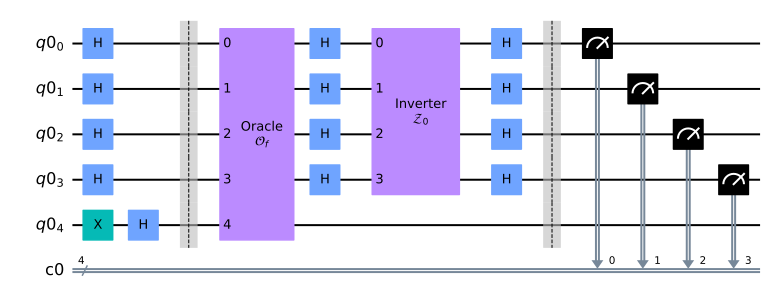

In [4]:
%config InlineBackend.figure_format = "svg"
from qiskit import QuantumRegister, ClassicalRegister

# Create registers and circuit object
def GroverAlg(f, n):
    qr, cr = QuantumRegister(n+1), ClassicalRegister(n)
    
    # Populate circuit
    circuit = QuantumCircuit(qr, cr)
    circuit.x(n)
    circuit.h(range(n+1))
    circuit.barrier()
    circuit = circuit + GroverOperator(f, n, qr, cr)
    circuit.barrier()
    circuit.measure(range(n), range(n))
    
    return circuit

GroverAlg(oracle_func, 4).draw(output="mpl")

## Simulation with Qiskit Aer

Now that we built our circuit, lets simulate it using `Qiskit`!

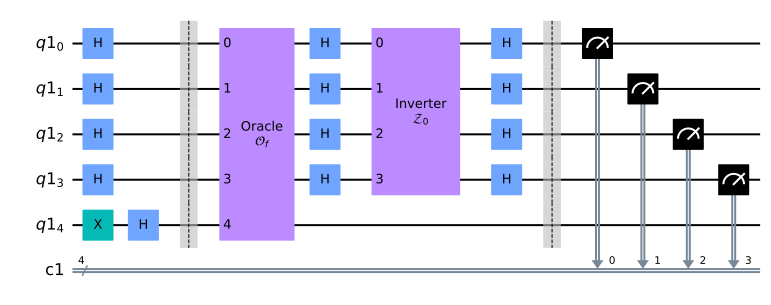

In [5]:
%matplotlib inline

from qiskit.tools.visualization import plot_histogram
from qiskit import Aer, execute

# Apply Grover's algorithm on 4 QuBits
circuit = GroverAlg(oracle_func, 4)
simulator = Aer.get_backend("qasm_simulator")
result = execute(circuit, backend=simulator, shots=1024).result()
circuit.draw(output="mpl")

If we take a look at the measurements, we will see that the QuBit corresponding to the index of the list containing our selected element has a considerably higher measurement probability, therefore we have found our answer!

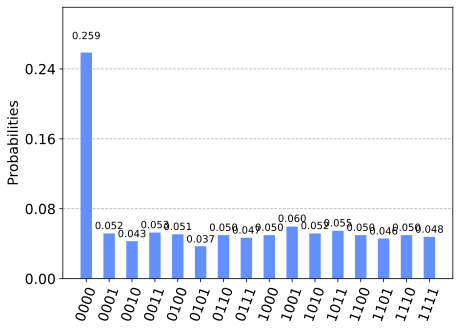

In [6]:
plot_histogram(result.get_counts(circuit))